# import libraries

In [3]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import itertools  
import math
import itertools
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers import LSTM, Embedding, Bidirectional
from keras.models import Model
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report 

import tensorflow as tf

## reading data to be trained

In [4]:
# reading data from csv files

path = r'C:\Users\91901\Code Here\CQA\dataset\Subtask A'

train_base = pd.read_csv(os.path.join(path,'TRAIN-BASE.csv'))
test_base = pd.read_csv(os.path.join(path,'TEST-BASE.csv'))
val_base = pd.read_csv(os.path.join(path,'VAL-BASE.csv'))

def read_df(df):
    f = df['feature'].tolist()
    x = df['question'].tolist()
    xx = df['answer'].tolist()
    y = df['labels'].tolist()
    return f, x, xx, y

f_train, x_train, xx_train, y_train = read_df(train_base)
f_test, x_test, xx_test, y_test = read_df(test_base)
f_val, x_val, xx_val, y_val = read_df(val_base)

# PRINT AND CHECK TRAINING, TESTING AND VALIDATION SET

print('\nTraining: ', len(f_train), len(x_train), len(xx_train), len(y_train)) #must be same
print('\nTesting: ', len(f_test), len(x_test), len(xx_test), len(y_test))
print('\nValidation: ', len(f_val), len(x_val), len(xx_val), len(y_val))


Training:  19580 19580 19580 19580

Testing:  6840 6840 6840 6840

Validation:  4950 4950 4950 4950


# UPSAMPLING (training, validation) and RE-MAKE all Test sets using train-test-split()

Upsampled Training Data and Validation Data. Combined these with given Test Data. Made new Training, Testing sets using sklearn. Validation Split 0.50 added in model.fit() 

In [5]:
# # SAMPLING ACCORDING TO LABELS 

feature_train, ques_train, ans_train, train_labels = f_train, x_train, xx_train, y_train
feature_test, ques_test, ans_test, test_labels = f_test, x_test, xx_test, y_test
feature_val, ques_val, ans_val, val_labels = f_val, x_val, xx_val, y_val


train_base = pd.DataFrame(
    {
    'feature':feature_train ,
    'question':ques_train,
    'answer':ans_train,
    'labels':train_labels
    })

test_base = pd.DataFrame(
    {
    'feature':feature_test ,
    'question':ques_test,
    'answer':ans_test,
    'labels':test_labels
    })

val_base = pd.DataFrame(
    {
    'feature':feature_val ,
    'question':ques_val,
    'answer':ans_val,
    'labels':val_labels
    })

In [6]:
# if one function for all train, test, validation 
def oversampling_function(base):

    bad_count, good_count, useful_count = base['labels'].value_counts()
    
    class_0 = base[base['labels'] == 'Bad']
    class_1 = base[base['labels'] == 'PotentiallyUseful']
    class_2 = base[base['labels'] == 'Good']

    ## print the shape of the class
    
    print('\n\nclass bad 0:', class_0.shape)
    print('class useful 1:', class_1.shape)
    print('class good 2:', class_2.shape)
    
    
    ## OVERSAMPLNG
    
    class_good = class_2.sample(bad_count, replace=True)
    class_useful = class_1.sample(bad_count, replace=True)

    oversampled_base = pd.concat([class_0, class_useful, class_good], axis = 0)
    print("Oversampled - Total class counts:\n", oversampled_base['labels'].value_counts())

#     print(oversampled_base['labels'].value_counts().plot(kind='bar', title = 'count (labels)'))

    return oversampled_base


print("Upsampling training Pool")
train_pool = oversampling_function(train_base)
val_pool = oversampling_function(val_base)
test_pool = test_base
#NEW TRAINING, TESTING, VALIDATION SET SIZES

print("\ntraining pool size after upsampling:", train_pool.shape)
print("\nvalidation pool size after upsampling:",val_pool.shape)
print("\ntesting pool size after upsampling:",test_pool.shape)

Upsampling training Pool


class bad 0: (8835, 4)
class useful 1: (3502, 4)
class good 2: (7243, 4)
Oversampled - Total class counts:
 Good                 8835
Bad                  8835
PotentiallyUseful    8835
Name: labels, dtype: int64


class bad 0: (2299, 4)
class useful 1: (826, 4)
class good 2: (1825, 4)
Oversampled - Total class counts:
 PotentiallyUseful    2299
Good                 2299
Bad                  2299
Name: labels, dtype: int64

training pool size after upsampling: (26505, 4)

validation pool size after upsampling: (6897, 4)

testing pool size after upsampling: (6840, 4)


In [7]:
#combine train, validation
train_pool =  train_pool.append(val_pool, ignore_index = True) #combine train and validation pool
print("total training data now:\n ", len(train_pool))

total training data now:
  33402


In [8]:
# TRAINING, VALIDATION, TESTING SETS


frames = [train_pool, test_pool, val_pool]
BASE = pd.concat(frames)
BASE.shape
BASE.labels.value_counts()

#%%

a, b = train_test_split(BASE, test_size = 0.5)

f_train, x_train, xx_train, y_train = a['feature'], a['question'], a['answer'], a['labels']
f_test, x_test, xx_test, y_test = b['feature'], b['question'], b['answer'], b['labels']

# PRINT AND CHECK TRAINING, TESTING AND VALIDATION SET

print('\nTraining: ', len(f_train), len(x_train), len(xx_train), len(y_train)) #must be same
print('\nTesting: ', len(f_test), len(x_test), len(xx_test), len(y_test))



Training:  23569 23569 23569 23569

Testing:  23570 23570 23570 23570


# let's read and make embeddings for data

In [9]:
avg_feature_length = 10
avg_question_length = 20
avg_answer_length = 50
MAX_SEQUENCE_LENGTH = FINAL_SEQUENCE_LENGTH = 100

In [10]:
# FOR GLOVE VECTORS

def read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM):
    
    with open(os.path.join(GLOVE_DIR, 'glove.6B.'+ str(EMBEDDING_DIM)+'d.txt'),  encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


def pretrained_embedding_layer(word_to_vec_map, word_to_index, random_term):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map[random_term].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. 
    # Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

# GLOVE_DIR = 'glove.6B'
# GLOVE_DIR = r'C:\Users\NoBotsHere\codehere\CQACodes\qa_dataset\glove.6B'
GLOVE_DIR = r'C:\Users\91901\Code Here\CQA\dataset\glove.6B'

EMBEDDING_DIM = 50
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, "massage")

In [11]:
def generate_data_for_keras( t1, t2, t3, Y, 
                            word_index):

    t1_sequences = [] #first vector 
    t2_sequences = [] #second vector
    t3_sequences = [] #three vector

    for t1_keys in t1:
        t1_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t1_keys.lower().split()])
    
    for t2_keys in t2:
        t2_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t2_keys.lower().split()])
    
    for t3_keys in t3:
        t3_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t3_keys.lower().split()])
           
    # padding 
    # long sentences truncated to maxlen (last sequences are kept)
    # short sentences padded with 0 (pad are added at begining)
    t1_data = pad_sequences(t1_sequences, maxlen= avg_feature_length, padding='post')  
    t2_data = pad_sequences(t2_sequences, maxlen= avg_question_length, padding='post') 
    t3_data = pad_sequences(t3_sequences, maxlen= avg_answer_length, padding='post') 

    print('\nShape of question text data tensor:', t2_data.shape)
    print('\nShape of answer text data tensor:', t3_data.shape)
    print('\nShape of feature text data tensor:', t1_data.shape)
 
    
    y = []
    
    for t in Y:    
        if t =='Bad':
            y.append(0)
        elif t =='Good':
            y.append(2)
        elif t == 'PotentiallyUseful':
            y.append(1)
    
       
    label = np.array(y)
    print('\nShape of label data tensor:', label.shape)
    print('\nlabel data:', label)
    
    return t1_data, t2_data, t3_data, label


# # data for keras layers
#T1 IS FIRST TEXT FEATURE TEXT
#T2 IS QUESTION TEXT 
#T3 IS ANSWER TEXT
print('\nTraining: ') 
t1_train, t2_train, t3_train, y_train  = generate_data_for_keras(f_train, x_train, xx_train, y_train, word_to_index)

print('\nTesting: ')
t1_test, t2_test, t3_test, y_test  = generate_data_for_keras(f_test, x_test, xx_test, y_test, word_to_index)

print('\nTraining: ', len(t1_train), len(t2_train), len(t3_train), len(y_train)) #must be same
print('\nTesting: ', len(t1_test), len(t2_test), len(t3_test), len(y_test))



Training: 

Shape of question text data tensor: (23569, 20)

Shape of answer text data tensor: (23569, 50)

Shape of feature text data tensor: (23569, 10)

Shape of label data tensor: (23569,)

label data: [0 1 1 ... 2 2 2]

Testing: 

Shape of question text data tensor: (23570, 20)

Shape of answer text data tensor: (23570, 50)

Shape of feature text data tensor: (23570, 10)

Shape of label data tensor: (23570,)

label data: [0 2 1 ... 1 1 1]

Training:  23569 23569 23569 23569

Testing:  23570 23570 23570 23570


In [12]:
# DISPLAY training, testing and validation data 

print('------- Training Data -------\n')
for i in range (2):
    print ('Entry:', t1_train[i] , '\n', t2_train[i] , '\n', t3_train[i] , '\nLabel:' , y_train[i], '\n')
      
print('------- Testing Data -------\n')
for i in range (2):
    print ('Entry:', t1_test[i] , '\n', t2_test[i] , '\n', t3_test[i] , '\nLabel:' , y_test[i], '\n')


------- Training Data -------

Entry: [182540 360915 305510  90577 278457      0      0      0      0      0] 
 [110523 185457  90548 374163 360915 324838 254258  57836 360915 357266
  90577 107908 188481      0 394565 176551 192973 166408      0 237436] 
 [     0 383514 357640  54273  46224  97097 151349      0 193716 338190
 336114 132683 305516  43010  90577 278456      0 188481 310920 357810
  97103 337267 185457 209645  43010   5382 141545 143109 151349  43010
      0 146307  62065 357266  90577      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0] 
Label: 0 

Entry: [87768 71851     0     0     0     0     0     0     0     0] 
 [193919 336114 173236 360915  99949 357266 269953 394475 357970 387696
  71090 357266  74390 151349 394565      0  57170      0 357161      0] 
 [389883 248214  30387 117967 296919  11092 281063 249156  21828 117967
 296919   9028 281063 249156  15341 117967 296919   5587 281063 249156
      0 390052 38

# Preparing Contextualized Embeddings

In [13]:
%%time

# Prepare embeddings sequences by initializing keras embedding layer with glove embedding values

sequence_input_feat = Input(shape=(avg_feature_length,), dtype='int32', name='featureLayer')
embedded_feat_sequences = embedding_layer(sequence_input_feat)
      
sequence_input_ques = Input(shape=(avg_question_length,), dtype='int32', name='questionLayer')
embedded_ques_sequences = embedding_layer(sequence_input_ques)


sequence_input_ans = Input(shape=(avg_answer_length,), dtype='int32', name='answerLayer')
embedded_ans_sequences = embedding_layer(sequence_input_ans)

Wall time: 44.9 ms


In [14]:
%%time

def bilstm_embeddings(embedded_sequences):

   
    n = Bidirectional(LSTM(nn_units, return_sequences= True, 
                            name = 'bilstm_layer', dropout = dropout_inputs, 
                            recurrent_dropout = recurrent_dropout_inputs))(embedded_sequences)

    return n

Wall time: 0 ns


# Model definition for Classification


In [15]:
# default helpful

INPUT_SEQUENCES = [sequence_input_feat, sequence_input_ques, sequence_input_ans]
TRAIN_FIT = [t1_train, t2_train, t3_train]

In [16]:
# defining model

def classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES):
    
    # FOR MODEL_1 
    
    FinalLayer = keras.layers.concatenate(inputs = INPUT_EMBEDDINGS, axis = 1)
    FinalLayer = keras.layers.GlobalAveragePooling1D()(FinalLayer)
    predictions = Dense(3, activation = "softmax")(FinalLayer)

    # MODEL_1 FOR ANSWER SELECTION

    model = Model(inputs = INPUT_SEQUENCES , outputs = predictions)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
    
    model.summary()

    return model

# Common functions - Plot, Evaluate, Save Results

# Training Model

In [17]:
def training_model(model, MODEL_NAME, TRAIN_FIT):
    

    callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)
    checkpoint_path = os.path.join(MODEL_NAME + '_checkpoint.h5')

    modelcheck_acc = ModelCheckpoint(checkpoint_path, 
                                     monitor='acc', mode='max', 
                                    save_best_only = True, verbose=1)

    CALLBACK = [callback, modelcheck_acc]

    history = model.fit(TRAIN_FIT, y_train, 
                            batch_size = batchsize, 
                            epochs = epochs_count, 
                            validation_split = 0.50, 
                            callbacks = CALLBACK
                           )
    return history

In [18]:
# into files save
  
# model_directory = "Resulting Model"
# MODEL_SAVING_DIR = os.path.join(path, model_directory)
# os.mkdir(MODEL_SAVING_DIR) 
 
# MODEL_SAVING_DIR = (r'\folder-path')

def save_models(model, MODEL_NAME):
  
    # serialize model to JSON
    model_json = model.to_json()
    with open(MODEL_NAME + ".json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(MODEL_NAME + ".h5")
    print("\nTHIS MODEL HAS BEEN SAVED TO DIRECTORY: ", os.getcwd())

In [19]:
def plot_graphs(history, string):
    print('training of model')
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [20]:
def plot_both_graphs(history):
    # plot train and validation loss
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # plot train and validation loss
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model train vs validation acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    

In [21]:
def evaluate_model(model):
    # Returns the loss value & metrics values for the model in test mode.
    print("Evaluated on metrics ", model.metrics_names)

    score_loss, score_acc = model.evaluate([t1_test, t2_test, t3_test], y_test, batch_size=batchsize)
    print("Test Loss :", score_loss, "Test Accuracy: ", score_acc)

    # MODEL_1 FOR PREDICTIONS 
    model_predictions = model.predict([t1_test, t2_test, t3_test])
    print("\npredictions shape is: ", model_predictions.shape)
#     print("\nand few predictions are:\n", model_predictions[:3], "\n\n while original test labels look like: ", y_test[:10])

    #To find the predicted class for each test example, you need to use axis=1
    predicted_class_names = np.argmax(model_predictions, axis = 1)
    print("\n\n Predictions into Class Labels:", predicted_class_names)

    print("\n\n METRICS CLASSIFICATION REPORT IS:\n", classification_report (y_test, np.argmax(model_predictions, axis = 1)))
    
    return model_predictions, predicted_class_names

In [22]:
def result_store(predicted_class_names):
    
    df = pd.DataFrame(columns = ['feature', 'text_1', 'text_2', 'true_label'])
    df['feature'] = f_test
    df['text_1'] = x_test
    df['text_2'] = xx_test
    df['true_label'] = y_test
    df['predicted_label'] = predicted_class_names

    return df

In [23]:
## put into files these 


# df_true_labels = pd.DataFrame(y_test, columns = ['y_test_labels'])
# df_true_labels.y_test_labels.value_counts()
# df_true_labels.head()

# df_pred_labels = pd.DataFrame(predicted_class_names_1, columns = ['y_pred_labels'])
# df_pred_labels.y_pred_labels.value_counts()
# df_pred_labels.head()

# print("no of true labels:\n", df_true_labels.y_test_labels.value_counts())
# print("no of predicted labels:\n", df_pred_labels.y_pred_labels.value_counts())

## Model_bilstm for Classification

In [24]:
# define parameters 

nn_units = 128
dropout_inputs = 0.2
recurrent_dropout_inputs = 0.15
batchsize = 64
epochs_count = 100

# call for embeddings

n1 = bilstm_embeddings(embedded_feat_sequences)
n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

print(n1)
print(n2)
print(n3)

Tensor("bidirectional_1/concat:0", shape=(None, 10, 256), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(None, 20, 256), dtype=float32)
Tensor("bidirectional_3/concat:0", shape=(None, 50, 256), dtype=float32)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
featureLayer (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
questionLayer (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
answerLayer (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             20000050    featureLayer[0][0]               
                                                                 questionLayer[0][0]        

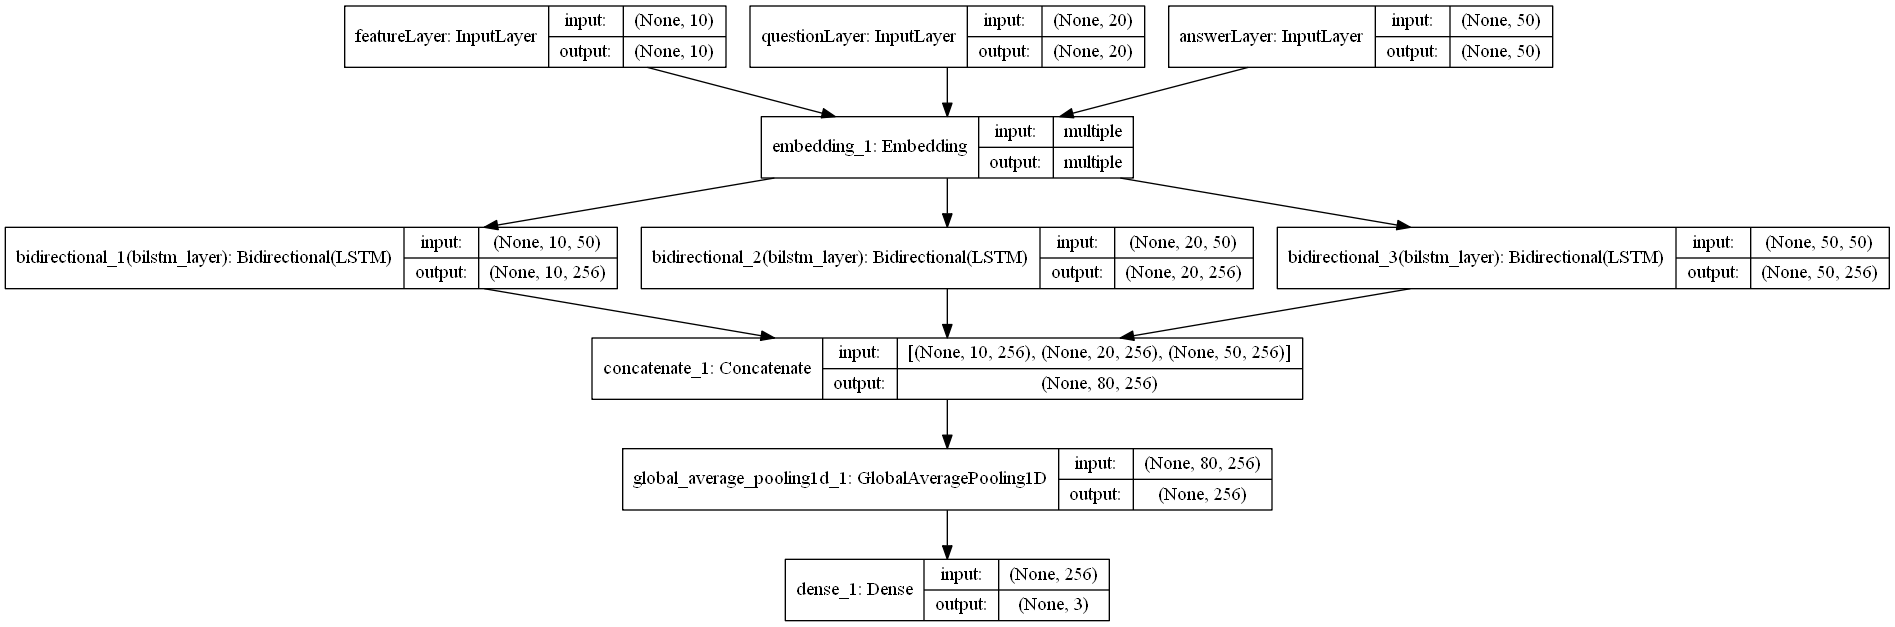

In [25]:
#CUSTOM COLUMNS

INPUT_EMBEDDINGS = [n1, n2, n3]

model_bilstm = classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_bilstm, to_file = 's2-model_bilstm.png', show_shapes=True, show_layer_names=True)

In [26]:
history_bilstm = training_model(model_bilstm, 's2-model-bilstm', TRAIN_FIT) 
save_models(model_bilstm, 's2-model-bilstm')

Train on 11784 samples, validate on 11785 samples
Epoch 1/100
11784/11784 [==============================] - 22s 2ms/step - loss: 1.0299 - acc: 0.4694 - val_loss: 1.0208 - val_acc: 0.4815

Epoch 00001: acc improved from -inf to 0.46937, saving model to s2-model-bilstm_checkpoint.h5
Epoch 2/100
11784/11784 [==============================] - 18s 2ms/step - loss: 0.9961 - acc: 0.5015 - val_loss: 1.0163 - val_acc: 0.4947

Epoch 00002: acc improved from 0.46937 to 0.50153, saving model to s2-model-bilstm_checkpoint.h5
Epoch 3/100
11784/11784 [==============================] - 18s 2ms/step - loss: 0.9776 - acc: 0.5232 - val_loss: 0.9832 - val_acc: 0.5165

Epoch 00003: acc improved from 0.50153 to 0.52317, saving model to s2-model-bilstm_checkpoint.h5
Epoch 4/100
11784/11784 [==============================] - 18s 2ms/step - loss: 0.9622 - acc: 0.5378 - val_loss: 0.9879 - val_acc: 0.5142

Epoch 00004: acc improved from 0.52317 to 0.53785, saving model to s2-model-bilstm_checkpoint.h5
Epoch 5/1

Epoch 36/100
11784/11784 [==============================] - 18s 2ms/step - loss: 0.5300 - acc: 0.7839 - val_loss: 0.7761 - val_acc: 0.7022

Epoch 00036: acc improved from 0.78063 to 0.78394, saving model to s2-model-bilstm_checkpoint.h5
Epoch 37/100
11784/11784 [==============================] - 18s 2ms/step - loss: 0.5215 - acc: 0.7889 - val_loss: 0.7640 - val_acc: 0.7045

Epoch 00037: acc improved from 0.78394 to 0.78887, saving model to s2-model-bilstm_checkpoint.h5
Epoch 38/100
11784/11784 [==============================] - 18s 2ms/step - loss: 0.5120 - acc: 0.7946 - val_loss: 0.7685 - val_acc: 0.7089

Epoch 00038: acc improved from 0.78887 to 0.79464, saving model to s2-model-bilstm_checkpoint.h5
Epoch 39/100
11784/11784 [==============================] - 18s 2ms/step - loss: 0.5063 - acc: 0.7971 - val_loss: 0.8086 - val_acc: 0.7056

Epoch 00039: acc improved from 0.79464 to 0.79710, saving model to s2-model-bilstm_checkpoint.h5
Epoch 40/100
11784/11784 [==========================


Epoch 00072: acc improved from 0.89664 to 0.89672, saving model to s2-model-bilstm_checkpoint.h5
Epoch 73/100
11784/11784 [==============================] - 17s 1ms/step - loss: 0.2694 - acc: 0.8993 - val_loss: 1.0324 - val_acc: 0.7372

Epoch 00073: acc improved from 0.89672 to 0.89927, saving model to s2-model-bilstm_checkpoint.h5
Epoch 74/100
11784/11784 [==============================] - 18s 1ms/step - loss: 0.2655 - acc: 0.8985 - val_loss: 0.8716 - val_acc: 0.7555

Epoch 00074: acc did not improve from 0.89927
Epoch 75/100
11784/11784 [==============================] - 18s 1ms/step - loss: 0.2628 - acc: 0.8999 - val_loss: 0.9026 - val_acc: 0.7532

Epoch 00075: acc improved from 0.89927 to 0.89995, saving model to s2-model-bilstm_checkpoint.h5
Epoch 76/100
11784/11784 [==============================] - 18s 1ms/step - loss: 0.2606 - acc: 0.9010 - val_loss: 0.9735 - val_acc: 0.7423

Epoch 00076: acc improved from 0.89995 to 0.90097, saving model to s2-model-bilstm_checkpoint.h5
Epoch

In [27]:
print(history_bilstm.history['loss'][-1])
print(history_bilstm.history['acc'][-1])

0.18631234264300942
0.9330448


training of model


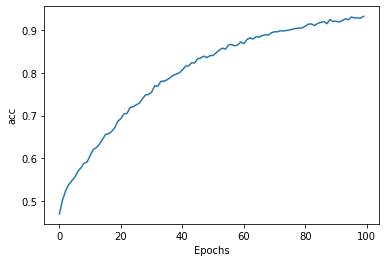

training of model


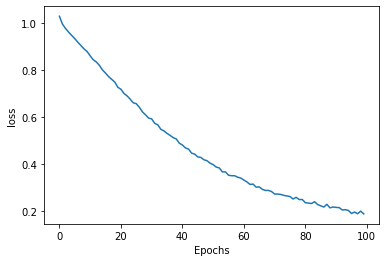

In [28]:
plot_graphs(history_bilstm, 'acc')
plot_graphs(history_bilstm, 'loss')

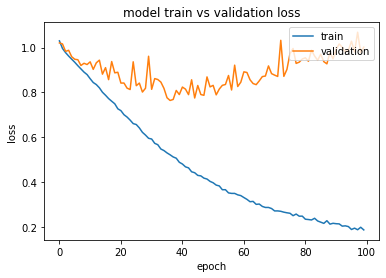

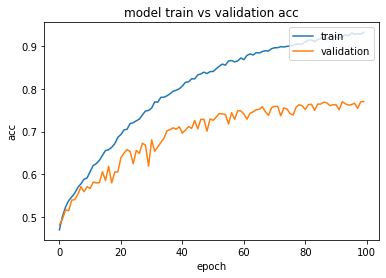

In [29]:
plot_both_graphs(history_bilstm)

In [30]:
model_predictions_bilstm, predicted_class_names_bilstm = evaluate_model(model_bilstm)

Evaluated on metrics  ['loss', 'acc']
23570/23570 [==============================] - 6s 241us/step
Test Loss : 0.9919579387520348 Test Accuracy:  0.7709376215934753

predictions shape is:  (23570, 3)


 Predictions into Class Labels: [0 2 0 ... 1 1 1]


 METRICS CLASSIFICATION REPORT IS:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77      8149
           1       0.77      0.77      0.77      7327
           2       0.76      0.78      0.77      8094

    accuracy                           0.77     23570
   macro avg       0.77      0.77      0.77     23570
weighted avg       0.77      0.77      0.77     23570



In [31]:
result_bilstm = result_store(predicted_class_names_bilstm)

print("no of true labels:\n", result_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_bilstm.predicted_label.value_counts())

result_bilstm.head()

no of true labels:
 0    8149
2    8094
1    7327
Name: true_label, dtype: int64
no of predicted labels:
 2    8321
0    7912
1    7337
Name: predicted_label, dtype: int64


,feature,text_1,text_2,true_label,predicted_label
28048,Bringing 2 small dogs into Qatar,Hi; Do you guys know what is the process to br...,thanks guys.. Yeah man; the GF is coming with ...,0,0
2629,Job Offer,Good Day to All! :) I have an offer for QR 200...,Don't accept if you have other option; if you ...,2,2
8883,Can anyone help regarding BAN in Qatar .,I came back from Qatar on 25th June 2013 after...,Rumors were flowing previously that it wil b i...,1,0
2123,Are there any 24 hour gyms in Qatar?,I am thinking of changing gyms when I go back ...,I was actually considering opening a gym too! ...,0,2
1094,Hamad Medical corp Salary,hey guys. I`m a nurse here in the phils. i jus...,hamad currently has 5 hospitals; and another o...,1,1


In [32]:
result_bilstm.sort_index()

,feature,text_1,text_2,true_label,predicted_label
0,Why finding a job in Doha so hard?,Can somebody tell me how i get a good job in d...,Are you Qatari? That may be the answer.,0,0
1,massage oil,is there any place i can find scented massage ...,dont want girls;want oil,0,0
1,Best Bank,Hi Guys; I need to open a new bank accoount. W...,The best bank in Qatar for you would be the on...,2,2
1,Why finding a job in Doha so hard?,Can somebody tell me how i get a good job in d...,No I am not qatari; but I can speak Arabic; It...,0,0
2,Best Bank,Hi Guys; I need to open a new bank accoount. W...,- Credit / Debit card facilities - Customer Ca...,1,1
...,...,...,...,...,...
33389,How expensive is Bahrain as compared to Qatar?,Can anyone please tell me how expensive (in te...,I used to pay a rent of 180 BD for a semifurni...,2,2
33395,Child dies in School bus in DPS,Today children returned late from School (DPS ...,yes i heard about that if its true who r the r...,2,1
33396,How much should I expect to save in 20;000/- pm ?,Hi; How much should I expect to save in 20;000...,I am giving you the figures which may give you...,2,2
33398,Women drivers!!! &^%&$^#&$&* x-(,What's the one thing you simply hate about the...,The woman do make-up while driving....lol,2,2


In [33]:
results_path = os.getcwd()
result_bilstm.to_csv(os.path.join(results_path,'s2-FQA-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

# Saving Experiment Details

    data description train-fit
    Parameters hidden units, dropouts, batchsize
    Model Description optimizer, activation, no of lstms, metrics
    Performance details training val test loss accuracy
    True vs Pred result.truelabel column and predictedlabel column
    

In [34]:
# parameter_details = {
#     'nn_units' : nn_units,
#     'dropout_inputs' 
# recurrent_dropout_inputs 
# batchsize 
# epochs_count 

# dropout_inputs 
# recurrent_dropout_inputs 
# batchsize 
# epochs_count 
    
# ]

# df_perf = pd.DataFrame(columns = ['model_name'])


# print(history_bilstm.history['loss'][-1])
# print(history_bilstm.history['acc'][-1])

# Stacked Model

In [35]:
# define parameters for stacked

nn_units = 64
dropout_inputs = 0.3
recurrent_dropout_inputs = 0.2
batchsize = 32
epochs_count = 80

# call for embeddings

n1 = bilstm_embeddings(embedded_feat_sequences)
n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

print(n1)
print(n2)
print(n3)

Tensor("bidirectional_4/concat:0", shape=(None, 10, 128), dtype=float32)
Tensor("bidirectional_5/concat:0", shape=(None, 20, 128), dtype=float32)
Tensor("bidirectional_6/concat:0", shape=(None, 50, 128), dtype=float32)


In [36]:
%%time


# call for stacked embeddings

def stacked_bilstm_embeddings(layer):
    
    for i in range(4):
#         print('run:', i, '--', 'layer-name:', layer)
        layer = Bidirectional(LSTM(nn_units, return_sequences= True, name = 'bilstm_layer', 
                        dropout=dropout_inputs, recurrent_dropout = recurrent_dropout_inputs))(layer)
    
    return layer

stacked_n1 = stacked_bilstm_embeddings(n1)
stacked_n2 = stacked_bilstm_embeddings(n2)
stacked_n3 = stacked_bilstm_embeddings(n3)

print(stacked_n1)
print(stacked_n2)
print(stacked_n3)

Tensor("bidirectional_10/concat:0", shape=(None, 10, 128), dtype=float32)
Tensor("bidirectional_14/concat:0", shape=(None, 20, 128), dtype=float32)
Tensor("bidirectional_18/concat:0", shape=(None, 50, 128), dtype=float32)
Wall time: 3h 32min 36s


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
featureLayer (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
questionLayer (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
answerLayer (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             20000050    featureLayer[0][0]               
                                                                 questionLayer[0][0]        

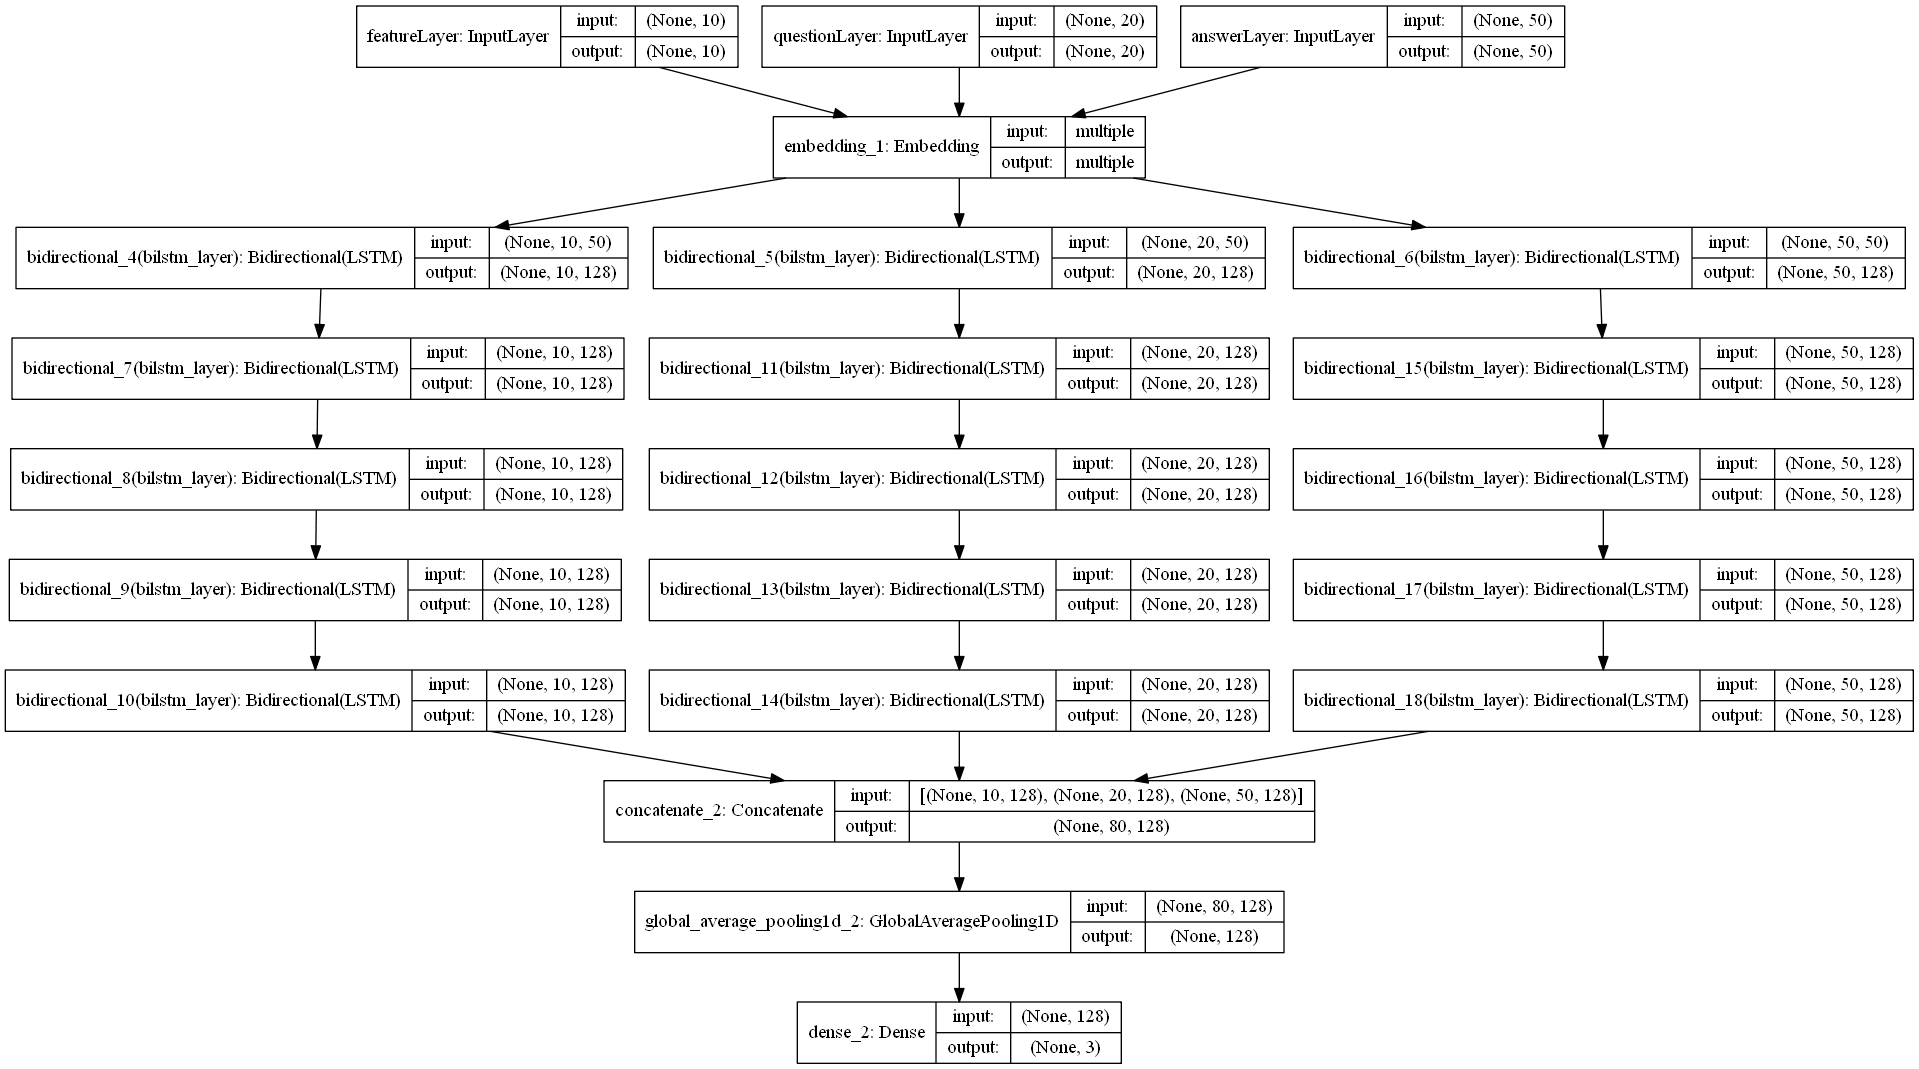

In [37]:
STACKED_EMBEDDINGS = [stacked_n1, stacked_n2, stacked_n3]

model_stacked_bilstm = classification_model(STACKED_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_stacked_bilstm, to_file = 's2-model_stacked_bilstm.png', show_shapes=True, show_layer_names=True)

In [38]:
history_stacked_bilstm = training_model(model_stacked_bilstm, 's2-model-stacked-bilstm', TRAIN_FIT) 

Train on 11784 samples, validate on 11785 samples
Epoch 1/80
11784/11784 [==============================] - 226s 19ms/step - loss: 1.0477 - acc: 0.4546 - val_loss: 1.0401 - val_acc: 0.4726

Epoch 00001: acc improved from -inf to 0.45460, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 2/80
11784/11784 [==============================] - 209s 18ms/step - loss: 1.0214 - acc: 0.4831 - val_loss: 1.0201 - val_acc: 0.4843

Epoch 00002: acc improved from 0.45460 to 0.48311, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 3/80
11784/11784 [==============================] - 208s 18ms/step - loss: 1.0053 - acc: 0.4998 - val_loss: 1.0138 - val_acc: 0.4631

Epoch 00003: acc improved from 0.48311 to 0.49983, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 4/80
11784/11784 [==============================] - 207s 18ms/step - loss: 0.9907 - acc: 0.5104 - val_loss: 1.0968 - val_acc: 0.4849

Epoch 00004: acc improved from 0.49983 to 0.51035, saving model to s2-model-st

Epoch 35/80
11784/11784 [==============================] - 206s 17ms/step - loss: 0.7192 - acc: 0.6945 - val_loss: 0.8399 - val_acc: 0.6426

Epoch 00035: acc improved from 0.68610 to 0.69450, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 36/80
11784/11784 [==============================] - 205s 17ms/step - loss: 0.7130 - acc: 0.6974 - val_loss: 0.8150 - val_acc: 0.6490

Epoch 00036: acc improved from 0.69450 to 0.69739, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 37/80
11784/11784 [==============================] - 204s 17ms/step - loss: 0.7104 - acc: 0.6982 - val_loss: 0.8166 - val_acc: 0.6572

Epoch 00037: acc improved from 0.69739 to 0.69823, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 38/80
11784/11784 [==============================] - 206s 17ms/step - loss: 0.7046 - acc: 0.6999 - val_loss: 0.8194 - val_acc: 0.6561

Epoch 00038: acc improved from 0.69823 to 0.69993, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 39/80
1178

Epoch 71/80
11784/11784 [==============================] - 207s 18ms/step - loss: 0.5346 - acc: 0.7875 - val_loss: 0.7833 - val_acc: 0.7162

Epoch 00071: acc improved from 0.78310 to 0.78751, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 72/80
11784/11784 [==============================] - 207s 18ms/step - loss: 0.5331 - acc: 0.7845 - val_loss: 0.7779 - val_acc: 0.7129

Epoch 00072: acc did not improve from 0.78751
Epoch 73/80
11784/11784 [==============================] - 205s 17ms/step - loss: 0.5254 - acc: 0.7907 - val_loss: 0.7755 - val_acc: 0.7151

Epoch 00073: acc improved from 0.78751 to 0.79073, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 74/80
11784/11784 [==============================] - 205s 17ms/step - loss: 0.5287 - acc: 0.7855 - val_loss: 0.7856 - val_acc: 0.7126

Epoch 00074: acc did not improve from 0.79073
Epoch 75/80
11784/11784 [==============================] - 204s 17ms/step - loss: 0.5203 - acc: 0.7928 - val_loss: 0.7687 - val_acc: 0

In [39]:
save_models(model_stacked_bilstm, 's2-model_stacked_bilstm')


THIS MODEL HAS BEEN SAVED TO DIRECTORY:  C:\Users\91901\Code Here\CQA\1 go-to files functions\task-A


training of model


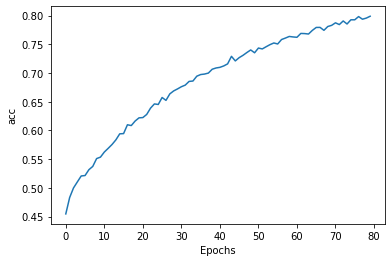

training of model


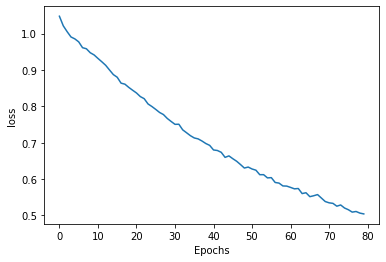

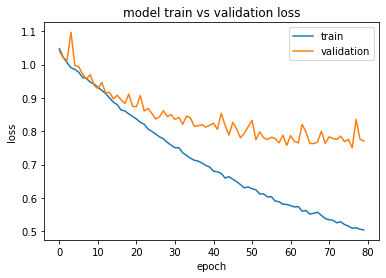

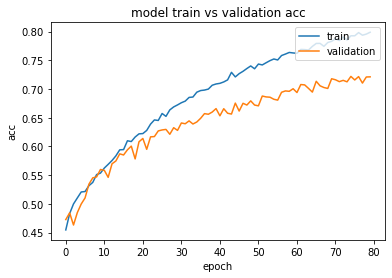

In [40]:
plot_graphs(history_stacked_bilstm, 'acc')
plot_graphs(history_stacked_bilstm, 'loss')
plot_both_graphs(history_stacked_bilstm)

In [41]:
model_predictions_stacked_bilstm, predicted_class_names_stacked_bilstm = evaluate_model(model_stacked_bilstm)

Evaluated on metrics  ['loss', 'acc']
23570/23570 [==============================] - 66s 3ms/step
Test Loss : 0.7721153896493228 Test Accuracy:  0.7232922911643982

predictions shape is:  (23570, 3)


 Predictions into Class Labels: [0 2 2 ... 1 1 1]


 METRICS CLASSIFICATION REPORT IS:
               precision    recall  f1-score   support

           0       0.76      0.75      0.75      8149
           1       0.72      0.65      0.68      7327
           2       0.70      0.76      0.73      8094

    accuracy                           0.72     23570
   macro avg       0.72      0.72      0.72     23570
weighted avg       0.72      0.72      0.72     23570



In [42]:
result_stacked_bilstm = result_store(predicted_class_names_stacked_bilstm)

print("no of true labels:\n", result_stacked_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_stacked_bilstm.predicted_label.value_counts())

result_stacked_bilstm.head()

no of true labels:
 0    8149
2    8094
1    7327
Name: true_label, dtype: int64
no of predicted labels:
 2    8822
0    8105
1    6643
Name: predicted_label, dtype: int64


,feature,text_1,text_2,true_label,predicted_label
28048,Bringing 2 small dogs into Qatar,Hi; Do you guys know what is the process to br...,thanks guys.. Yeah man; the GF is coming with ...,0,0
2629,Job Offer,Good Day to All! :) I have an offer for QR 200...,Don't accept if you have other option; if you ...,2,2
8883,Can anyone help regarding BAN in Qatar .,I came back from Qatar on 25th June 2013 after...,Rumors were flowing previously that it wil b i...,1,2
2123,Are there any 24 hour gyms in Qatar?,I am thinking of changing gyms when I go back ...,I was actually considering opening a gym too! ...,0,2
1094,Hamad Medical corp Salary,hey guys. I`m a nurse here in the phils. i jus...,hamad currently has 5 hospitals; and another o...,1,0


In [43]:
results_path = os.getcwd() 
result_stacked_bilstm.to_csv(os.path.join(results_path,'s2-FQA-STACKED-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

In [44]:
t = result_stacked_bilstm.sort_index()

In [45]:
t.head(50)

,feature,text_1,text_2,true_label,predicted_label
0,Why finding a job in Doha so hard?,Can somebody tell me how i get a good job in d...,Are you Qatari? That may be the answer.,0,0
1,massage oil,is there any place i can find scented massage ...,dont want girls;want oil,0,0
1,Best Bank,Hi Guys; I need to open a new bank accoount. W...,The best bank in Qatar for you would be the on...,2,2
1,Why finding a job in Doha so hard?,Can somebody tell me how i get a good job in d...,No I am not qatari; but I can speak Arabic; It...,0,0
2,Best Bank,Hi Guys; I need to open a new bank accoount. W...,- Credit / Debit card facilities - Customer Ca...,1,1
2,massage oil,is there any place i can find scented massage ...,you mean oil and filter both,0,0
2,Why finding a job in Doha so hard?,Can somebody tell me how i get a good job in d...,Not easy..... unless you have a father's rp or...,2,2
3,Why finding a job in Doha so hard?,Can somebody tell me how i get a good job in d...,Wasta my child...thats all it takes. Having Am...,2,2
4,Best Bank,Hi Guys; I need to open a new bank accoount. W...,Any bank other than Doha Bank ;),2,2
4,Why finding a job in Doha so hard?,Can somebody tell me how i get a good job in d...,also as tahsinmim said..helps sometimes to han...,0,0
